# Introduction

The objective of this task is to form meaningful clusters for sound data that is unlabelled.

# Step 0: Imports and setup

The first step of this assignment is to load all the necessary libraries. Additionally, I filtered out all warnings that the code in this notebook might generate.

In [109]:
# Make all necessary imports
import torchaudio
import os
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import warnings
from zipfile import ZipFile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score

warnings.filterwarnings("ignore")

# Task 1: Data Loading, Exploration and Feature Extraction
The first step is to load data, make sense of it and extract the relevant features.

## Download the data
I have uploaded a copy of the dataset to my Google Drive and made it publicly available. I am going to download this dataset as a zip file, extract it and save it in a local directory.

In [33]:
# Google Drive download url for the audio dataset
dataset_download_url = "https://drive.google.com/uc?id=1ruxU5ENHvFatNMBCN1wD6xVMnJmCoLY4"

# Path to save the audio dataset zip file
dataset_zip_path = "unlabelled_data.zip"

# Path to save the extracted audio files
dataset_path = "unlabelled_data"

# Download the data into the zip path
gdown.download(dataset_download_url, dataset_zip_path, quiet=False)

# Make a directory to store the unzipped files
os.makedirs(dataset_path, exist_ok=True)

# Open the zip file, and extract its contents to the dataset directory
with ZipFile(dataset_zip_path, 'r') as z:
  z.extractall(dataset_path)

print(f"Files extracted to {dataset_path}")

Downloading...
From: https://drive.google.com/uc?id=1ruxU5ENHvFatNMBCN1wD6xVMnJmCoLY4
To: /content/unlabelled_data.zip
100%|██████████| 16.3M/16.3M [00:00<00:00, 28.3MB/s]


Files extracted to unlabelled_data


## Reading the audio files
Next, I am reading the audio files from disk into memory. For each audio file, I am storing its waveform and sample rate.

In [34]:
data = {}

# Load the audio files
for file in os.listdir(dataset_path):
  # Create a file path based on the dataset_path and file
  file_path = os.path.join(dataset_path, file)

  # Read the audio files metadata
  info = torchaudio.info(file_path)

  # Extract the sample_width for each audio file
  sample_width = info.bits_per_sample // 8

  # Extract the waveform and sample_rate
  waveform, sample_rate = torchaudio.load(file_path)

  # Save the waveform, sample rate and sample width
  data[file] = (waveform.numpy(), sample_rate, sample_width)

## Data Exploration

In this section, I am exploring the data to better understand how it is stored.

In [35]:
# Here is an example in my audio dataset
# The example is stored as a tuple of two values.
# The first value is an array that represents the waveform as a
# sequence of samples. The array is two-dimensional.
# The second value is the sample rate. It specifies how many
# samples were collected by second. So 8000 means 8000 samples
# per second or just 8kHz.
# The third values is the sample width. It specifies how many bytes were used to
# store a sample within the file.

data['0.wav']

(array([[ 2.1362305e-04,  1.2207031e-04,  9.1552734e-05, ...,
          3.3569336e-04,  1.2207031e-04, -3.0517578e-05]], dtype=float32),
 8000,
 2)

In [36]:
# The waveform has a shape of (1, 3307)
# I am guessing the first dimension represents the audio channels
# And the second dimension represents the samples in that audio channel
# This sample has one audio channel

data['0.wav'][0].shape

(1, 3307)

### Questions:
1. Do all audio files have the same number of samples?
2. Do they all have the same sample rate?

I will attempt to answer these questions in the code cell that follows

In [6]:
def increment_dictionary_key(dictionary, key):
  if key in dictionary:
    dictionary[key] += 1
  else:
    dictionary[key] = 1


def print_key_values(dictionary, header):
  print(f'{header}\n')
  for key, value in dictionary.items():
    print(f'{key}: {value}')


def enumerate_properties(data):
  unique_n_samples = {}
  unique_sample_rates = {}
  unique_sample_widths = {}

  # Loop through all the values, extracting the waveform and sample_rate
  for waveform, sample_rate, sample_width in data.values():

    # Extract the number of samples
    n_samples = waveform.shape[1]

    # Count the sample rate
    increment_dictionary_key(unique_sample_rates, sample_rate)

    # Count the n_samples
    increment_dictionary_key(unique_n_samples, n_samples)

    # Count the sample widths
    increment_dictionary_key(unique_sample_widths, sample_width)

  return unique_n_samples, unique_sample_rates, unique_sample_widths

# Enumerate the n_samples and sample_rates concurrently
n_samples, sample_rates, sample_widths = enumerate_properties(data)

# Print out the unique values
print_key_values(n_samples, "Number of Samples in Audio Files Tally")
print('\n\n')
print_key_values(sample_rates, "Samples Rates in Audio Files Tally")
print('\n\n')
print_key_values(sample_widths, "Sample Widths Tally")

Number of Samples in Audio Files Tally

2318: 1
2342: 4
2034: 1
3450: 2
3320: 2
2149: 3
2764: 2
2016: 3
3865: 1
2894: 1
4666: 1
3947: 1
4384: 2
2474: 2
3461: 2
3768: 1
2736: 1
2177: 1
3618: 1
3897: 1
4166: 1
3111: 1
2855: 1
4222: 2
3338: 2
2476: 1
4175: 4
3539: 3
6286: 1
3379: 4
4778: 2
2437: 1
3153: 3
5136: 1
3828: 1
2110: 2
2960: 1
3499: 1
2282: 1
4300: 3
3361: 3
4053: 1
5007: 1
4033: 1
2741: 1
1958: 1
3854: 2
3160: 2
3883: 1
4972: 1
2823: 4
3136: 1
3050: 5
2507: 2
4233: 1
3096: 2
2727: 1
3749: 1
3355: 5
6883: 1
2222: 1
3975: 1
4171: 1
2583: 2
3180: 1
2551: 1
3633: 1
3223: 3
2384: 2
3843: 1
7140: 1
4124: 2
3585: 2
4357: 2
2444: 1
2257: 3
1259: 1
3074: 1
2843: 2
2590: 3
2936: 5
3787: 2
3708: 2
3486: 2
3889: 1
2898: 3
3783: 2
3374: 2
3423: 3
2668: 1
4476: 1
3203: 1
6039: 1
3764: 3
1890: 1
5639: 1
2208: 1
3391: 1
5322: 1
4242: 2
3161: 1
3918: 3
2390: 1
2794: 1
2696: 2
2440: 2
2786: 1
3561: 1
4196: 1
4101: 4
3971: 2
3448: 3
5092: 1
3174: 1
3590: 1
4771: 1
3608: 3
3278: 2
2599: 1
2748: 1


### Results
From the results above, I have the answers to the two questions:
1. The audio files are not of equal duration, therefore they have different numbers of sample sizes.
2. The audio files have the sample rate, therefore we can compare them sample for sample.
3. All the audio files have the same sample width, 2 bytes.

### Questions
1. What is the longest audio file we have?
2. And what is the shortest?

In [37]:
n_samples_list = n_samples.keys()

longest_audio = max(n_samples_list)
shortest_audio = min(n_samples_list)

print("Longest Audio:", longest_audio)
print("Shortest Audio:", shortest_audio)

Longest Audio: 18262
Shortest Audio: 1148


## Feature Extraction

Next, we are going to extract features as MEL Spectrograms. Each audio file will be represented by one spectrogram.

In [86]:
# Store the extracted features
spectrograms = []

# Extract features
for waveform, sample_rate, _ in data.values():
  mel_spect = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_fft=longest_audio, hop_length=longest_audio + 1)
  mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
  spectrograms.append(mel_spect)

spectrograms = np.array(spectrograms)

In [88]:
spectrograms.shape

(3000, 1, 128, 1)

In [111]:
# Remove unnecessary dimensions
# This will remove the channels and __ dimensions
spectrograms = spectrograms.squeeze()
spectrograms.shape

(3000, 128)

## Visualisation (Before Reduction)

### Why we can't
The dataset presently has 128 dimensions. To visualise this data we can generate scatter plots or pair plots. However this is not ideal for the following reasons:

1. Scatter plots cannot be made with more than 3 dimensions. We could attempt to plot all the features, three at a time, but that would make it difficult to identify clusters as no single plot provides a complete picture.
2. Pair plots enable us to plot how features vary in relation to one another. However, because we can only see two features at a time, it can be very difficult to visualise the clusters formed.

Therefore, it is necessary to reduce the dimensions first so it is easier to visualise clusters.

### Additional reasons why reducing dimensions is important
Apart from the practical necessity of reducing dimensions it is also important in this context because we are dealing with sound data. In sound, certain frequencies are often used together, for example, the notes in chords in music. The notes that form chords are positively correlated, while those that are not part of the chord are negatively correlated to those that do. Because of these high correlations, we can take advantage of PCA to cluster the data effectively as it forms principal components as linear combinations of the original features.

# Task 3: Reduce Dimensionality

The objective of this task is to reduce the dimensionality of the data. We are going to use two techniques to do this: Principal Component Analysis and t-SNE.

## Principal Component Analysis

In [112]:
# Reduce dimensions to 10 using PCA
pca = PCA(n_components=10)
pca_spectrograms = pca.fit_transform(spectrograms)

# Extract and display the Explained Variance Ratio for all Principal Components
evr = pca.explained_variance_ratio_
print(f'Explained variability per principal component: {evr}')

Explained variability per principal component: [0.3241469  0.19168018 0.13006651 0.04591866 0.04067957 0.03111881
 0.02448112 0.01882689 0.01476282 0.01304758]


This tell us that the 60% of the variability in the data is represented by the first 3 components. So we can extract those features only and form a reduced dataset.

In [92]:
pca_spectrograms = pca_spectrograms[:, :3]
pca_spectrograms.shape

(3000, 3)

In [122]:
def plot_3d_scatter_for_unlabelled_data(data, title, axis_labels=["", "", ""]):
  # Create a figure to plot
  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(projection='3d')

  # Extract the features to plot
  x = data[:, 0]
  y = data[:, 1]
  z = data[:, 2]

  # Plot the features
  ax.scatter(x, y, z)

  # Label the figure
  ax.set_xlabel(axis_labels[0])
  ax.set_ylabel(axis_labels[1])
  ax.set_zlabel(axis_labels[2])
  ax.set_title(title)

  # Show the plot
  plt.show()

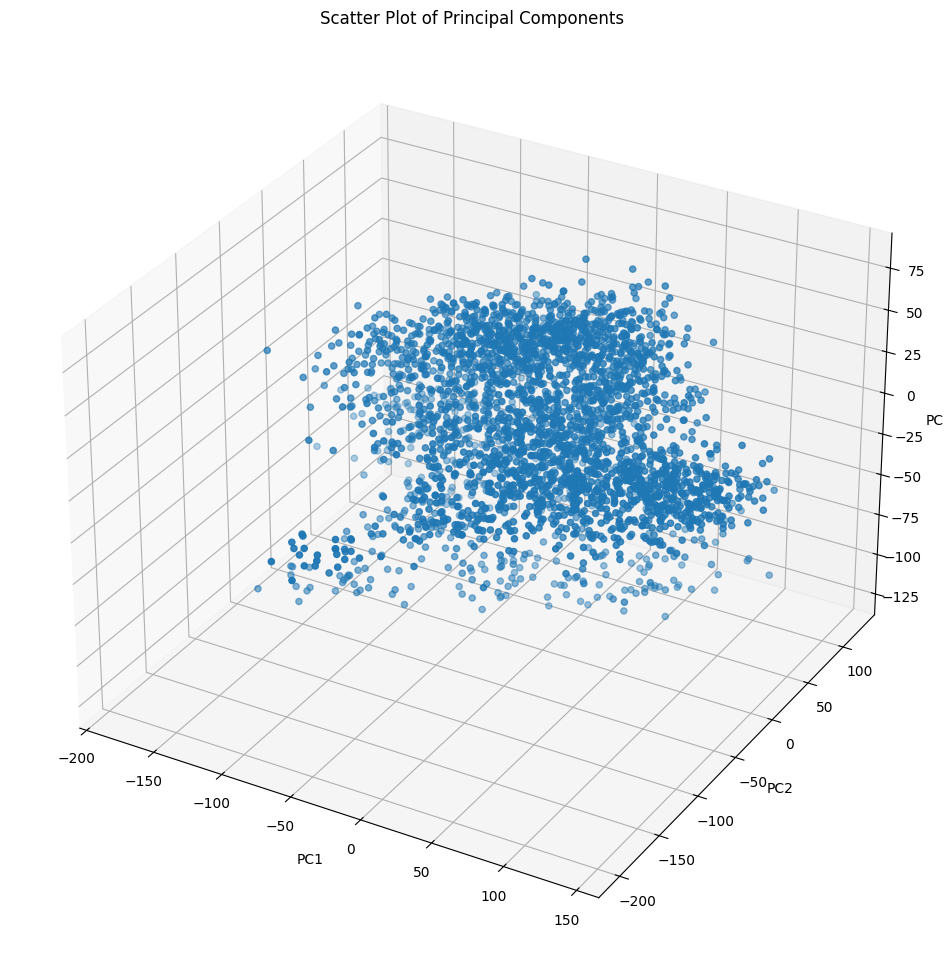

In [123]:
plot_3d_scatter_for_unlabelled_data(pca_spectrograms, 'Scatter Plot of Principal Components', ["PC1", "PC2", "PC3"])

## t-SNE

In [94]:
tsne = TSNE(n_components=3, random_state=42)
tsne_spectrograms = tsne.fit_transform(spectrograms)
tsne.kl_divergence_

0.6660952568054199

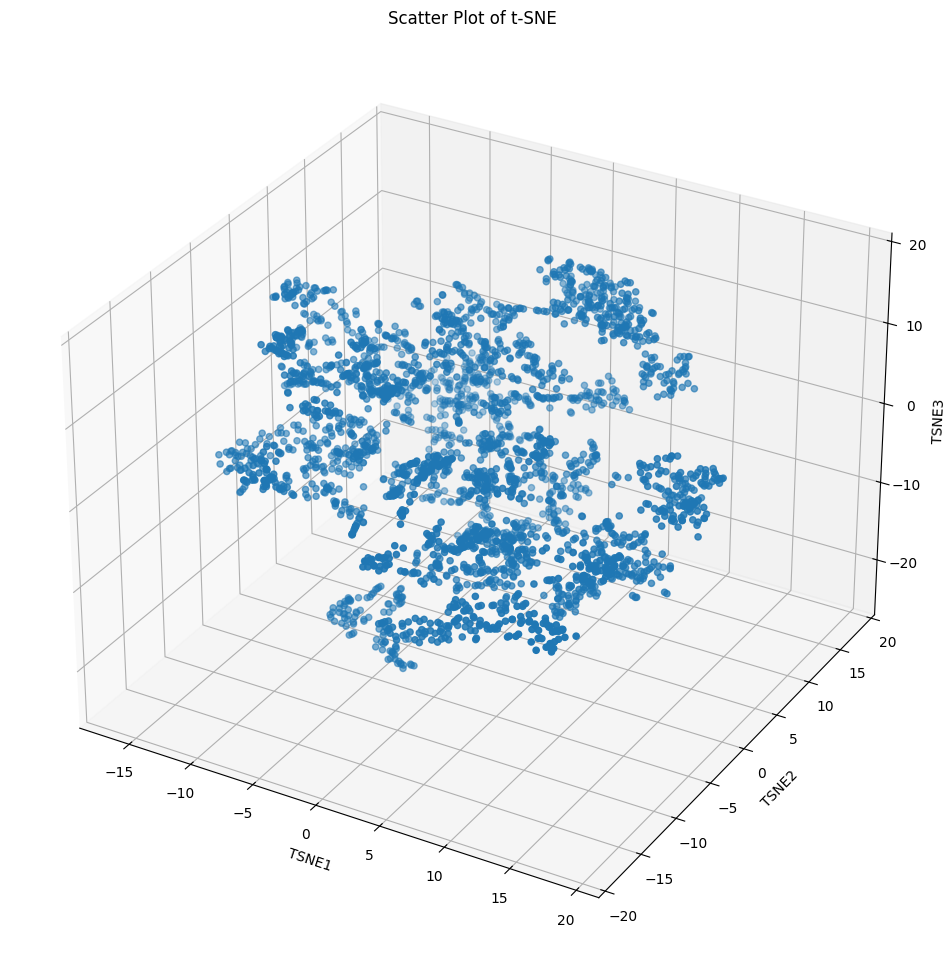

In [124]:
# Create a figure to plot
plot_3d_scatter_for_unlabelled_data(tsne_spectrograms, "Scatter Plot of t-SNE", ["TSNE1", "TSNE2", "TSNE3"])

Based on the plots above, it appears t-SNE provides better separability between clusters. Visually I can identify around 8 clusters on the t-SNE plot, while the PCA plot seems like one solid blob.

# Task 4: Clustering the Sound Data

Now that we have seen that the data can be clustered using t-SNE features, we are going to proceed and do just that. For this task, we are going to try two methods: KMeans and DBScan.

## KMeans Clustering

For KMeans Clustering, we are going to use I am going to use the elbow method to find the optimal number of clusters to create. Visually, I could tell there were about 8 clusters in the dataset. Therefore, I am going to search for clusters in the range 1 to 20, and find the elbow value.

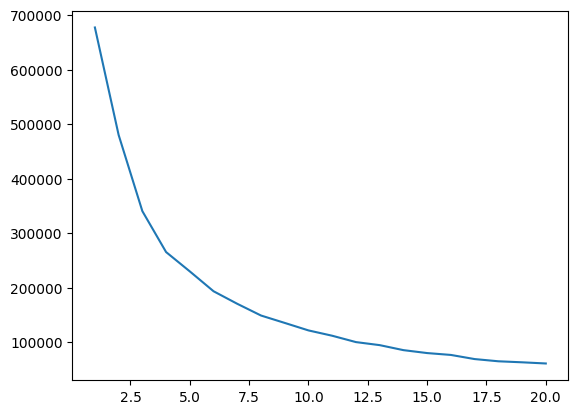

In [99]:
# From t-SNE I suspect that there are at around 8 clusters in the dataset.
# I am going to use KMeans and the Elbow method to find the optimal number of
# clusters between 1 and 20.
wcss = []

for i in range(1, 21):
  kmeans = KMeans(n_clusters=i, init='k-means++')
  kmeans.fit(tsne_spectrograms)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)

This suggests that the optimal number of clusters is around 10. Therefore, we will use that as the final number of clusters.

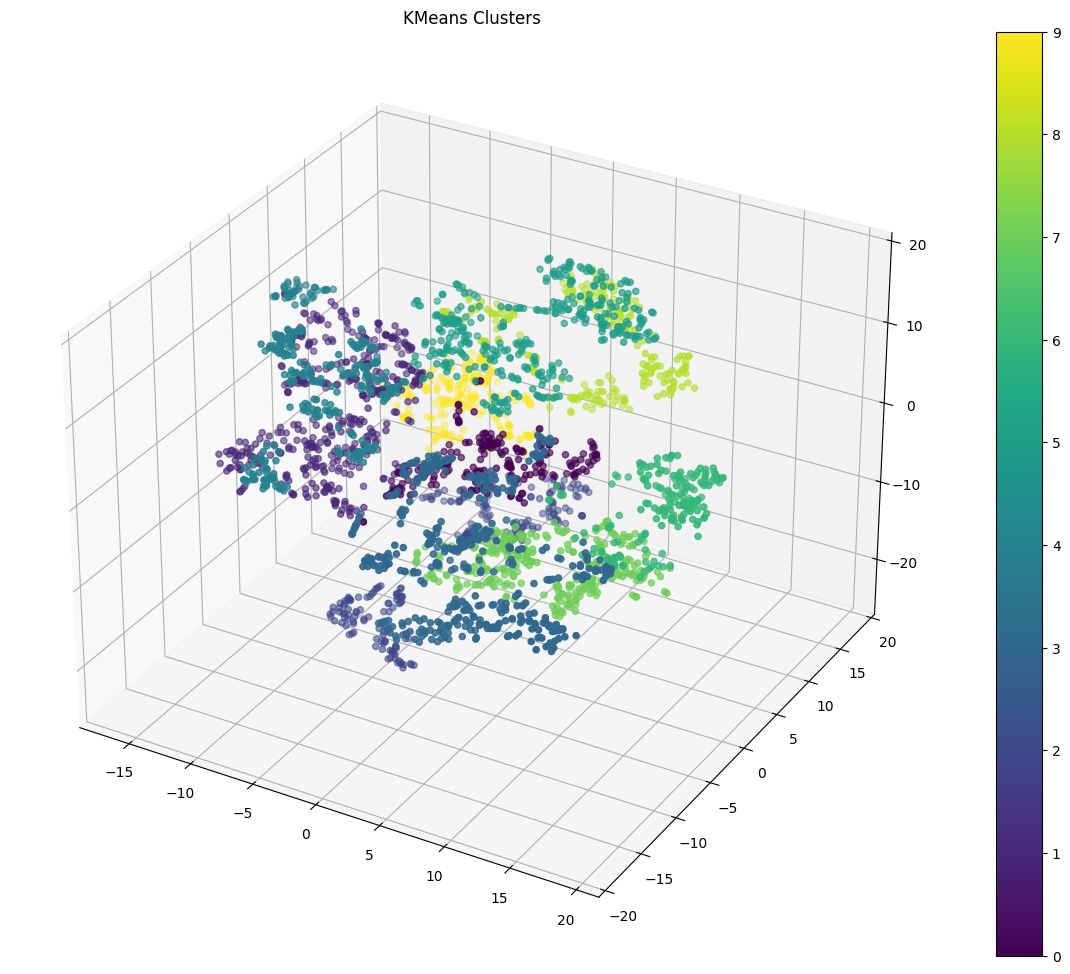

In [125]:
kmeans = KMeans(n_clusters=10)

kmeans_clusters = kmeans.fit_predict(tsne_spectrograms)

def plot_3d_scatter_for_labelled_data(X, labels, title):
  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(projection='3d')

  x = X[:, 0]
  y = X[:, 1]
  z = X[:, 2]

  scatter = ax.scatter(x, y, z, c=labels, cmap='viridis')

  plt.colorbar(scatter)
  plt.title(title)
  plt.show()

plot_3d_scatter_for_labelled_data(tsne_spectrograms, kmeans_clusters, "KMeans Clusters")

## DBSCAN

Next, we will experiment with DBSCAN. Like with KMeans, the first step is to find the optimal parameters.


### Finding Parameters
The DBSCAN algorithm requires two parameters:
- MinPts - The minimum number of points a point must have within its circle for it to be considered a core point.
- Epsilon - The size of the circle for the points.


Here's how to find the optimal parameters:

#### MinPts
The general recommendation is `2 * num_features`. After t-SNE, this dataset has 3 features. Therefore, the minimum number of points is going to be 6.

#### Epsilon
The recommended way is to first find the distance of each point to its kth nearest neighbour, where k = MinPts. Next, we plot these distances in ascending order and find an elbow in the graph.

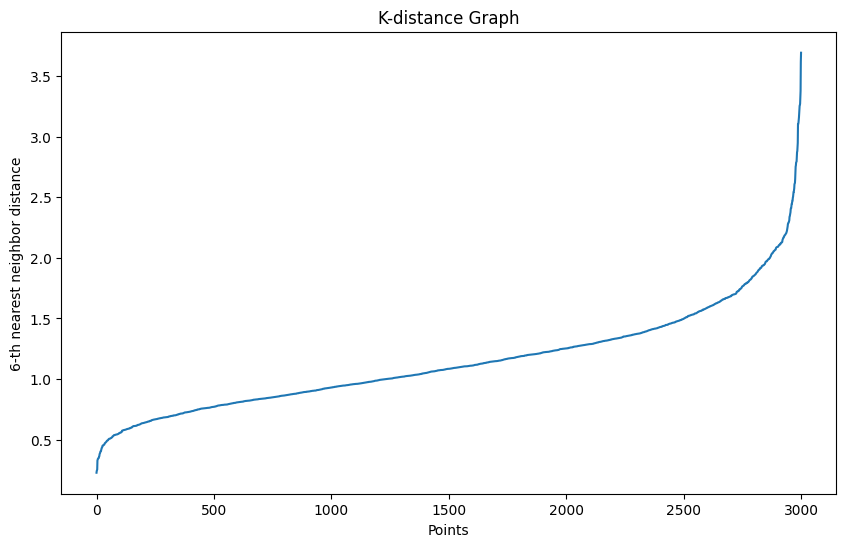

In [102]:
def plot_k_distance_graph(data, k):
  nearest_neighbors = NearestNeighbors(n_neighbors=k)
  nearest_neighbors.fit(data)
  distances, _ = nearest_neighbors.kneighbors(data)
  distances = np.sort(distances[:, k-1])

  plt.figure(figsize=(10, 6))
  plt.plot(distances)
  plt.xlabel('Points')
  plt.ylabel(f'{k}-th nearest neighbor distance')
  plt.title('K-distance Graph')
  plt.show()

plot_k_distance_graph(tsne_spectrograms, 6)

The graph shows that an epsilon value of 1.5 is ideal.

## Implement DBScan

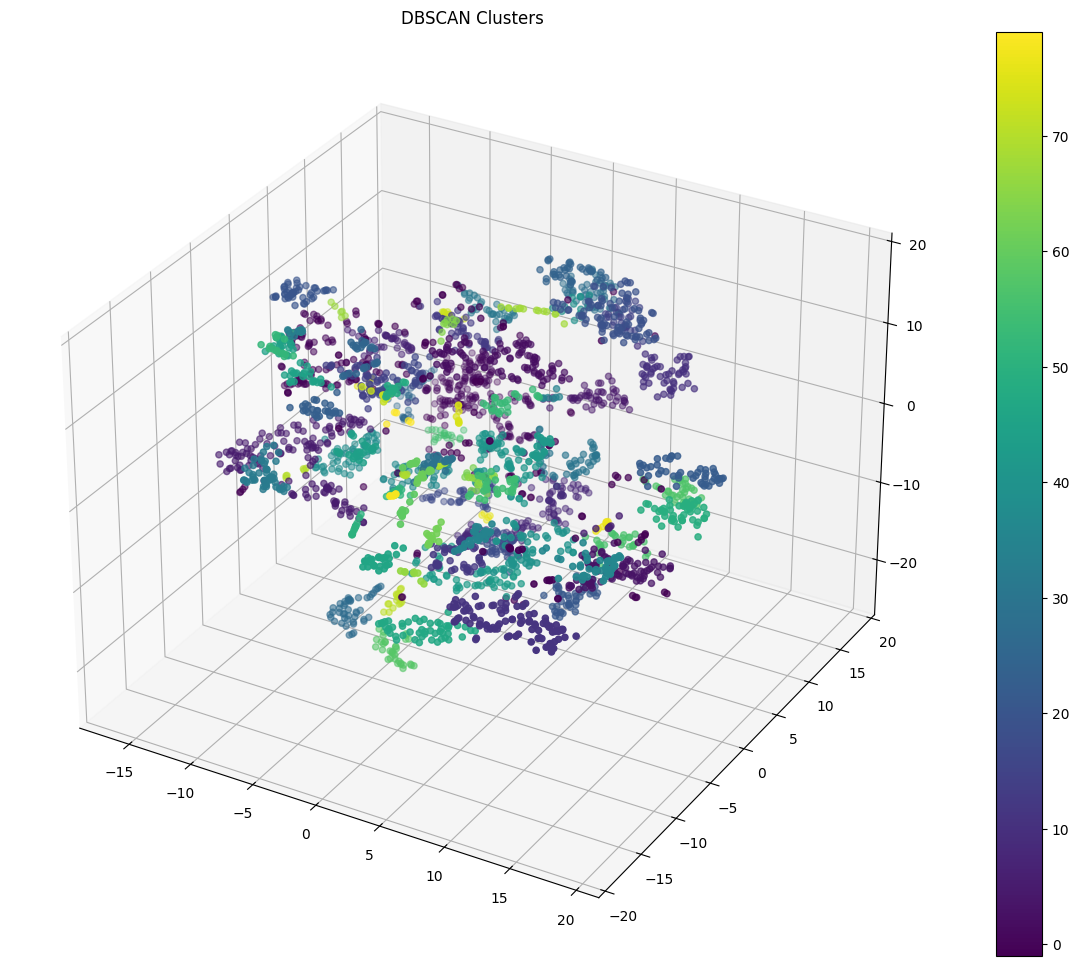

In [126]:
# Apply DBSCAN
epsilon = 1.5
min_samples = 6
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_clusters = dbscan.fit_predict(tsne_spectrograms)

# Visualise the results
plot_3d_scatter_for_labelled_data(tsne_spectrograms, dbscan_clusters, 'DBSCAN Clusters')

In [127]:
# Find out the number of clusters created by DBSCAN
len(set(dbscan_clusters))

81

# Task 5: Evaluating the Clustering Algorithms

## Scores

In [110]:
# Evaluate k-means clustering
kmeans_silhouette = silhouette_score(tsne_spectrograms, kmeans_clusters)
kmeans_db_index = davies_bouldin_score(tsne_spectrograms, kmeans_clusters)

# Evaluate dbscan clustering
dbscan_silhouette = silhouette_score(tsne_spectrograms, dbscan_clusters)
dbscan_db_index = davies_bouldin_score(tsne_spectrograms, dbscan_clusters)

# Display the results
print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")


K-Means - Silhouette Score: 0.3540, Davies-Bouldin Index: 0.9558
DBSCAN - Silhouette Score: 0.2895, Davies-Bouldin Index: 1.2261


## Visual Intepretation

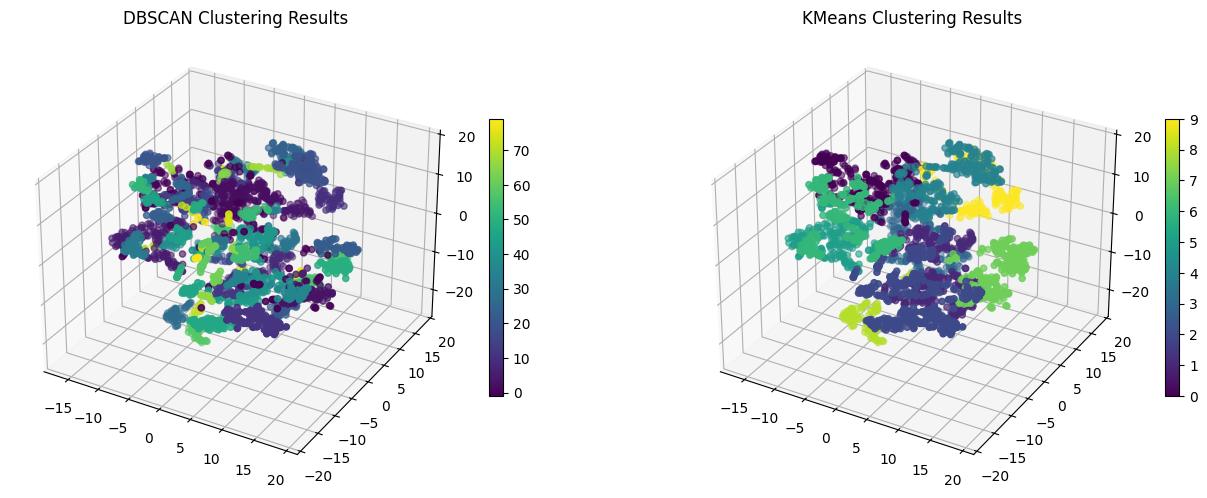

In [120]:
fig = plt.figure(figsize=(16, 6))

# K-Means Clustering Results
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(tsne_spectrograms[:, 0], tsne_spectrograms[:, 1], tsne_spectrograms[:, 2],
                        c=kmeans_clusters, cmap='viridis')
ax2.set_title('KMeans Clustering Results')
fig.colorbar(scatter2, ax=ax2, shrink=0.6)

# DBSCAN Clustering Results
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(tsne_spectrograms[:, 0], tsne_spectrograms[:, 1], tsne_spectrograms[:, 2],
                        c=dbscan_clusters, cmap='viridis')
ax1.set_title('DBSCAN Clustering Results')
fig.colorbar(scatter1, ax=ax1, shrink=0.6)

plt.show()

# Task 6: Intepreting the Evaluation

### Silhouette Scores
Silhouette scores measures the compactness of a cluster. K-Means had a higher score than DBSCAN meaning its clusters were more closely packed than those of DBSCAN. This indicates better performance for KMeans clusters.

### Davies-Bouldin Index
Davies-Bouldin Index measures the separation between clusters. K-Means had a lower score than DBSCAN. This meant that the clusters of K-Means were better separated than those of DBSCAN. This also indicates better performance for KMeans.

### Visual Interpretability
From the graphs above, it is clear to the eye that KMeans clusters are better separated and more compactly-packed than DBScans

### Final Verdict
KMeans, with 10 clusters, performed better than DBSCAN across all three metrics. Its inertia score was also good, though it could not be used to compare with DBSCAN as DBSCAN does not have centroids.



# Conclusion

## Dimensionality Reduction
Dimensionality Reduction helped to reduce the number of features which made it easier to identify clusters visually, and helped improve performance of clustering algorithm as there were fewer features to work with.

## Clustering
Overall, KMeans clustering worked best for my data with 10 clusters. DBSCAN performed poorly because it found 81 clusters, which is clearly excessive. This is very likely due to my my parameters, minimum number of points and epsilon. To improve the performance of DBSCAN, it might be necessary to optimise the parameters.

## Improvements
In the real world, dimensionality reduction will be useful to help reduce the complexity of datasets. Techniques I learnt and used such the elbow method for finding optimal parameters will also be useful. It would also be worthwhile to learn better hyperparameter selection strategies for DBSCAN, and to some extent, KMeans.